In [40]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [41]:
### Libraries for Data Handling

from pathlib import Path

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)

### Libraries for Algorithms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix
import sklearn.utils
import seaborn as sns

### Libraries for Data Visulation Tools
import matplotlib.pyplot as plt

In [42]:
data='/data/saikat/MIoT Paper/'

In [43]:
df = pd.read_csv(data+'heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [44]:
# Print the count of each class in the 'cardio' column
print(df['target'].value_counts())

1    526
0    499
Name: target, dtype: int64


In [45]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

exclude_column = ['sex','cp','fbs','restecg','exang','slope','ca','thal','target']

scale_columns = [col for col in df.columns if col not in exclude_column] 
print(scale_columns)

df[scale_columns] = scaler.fit_transform(df[scale_columns])
df.head()


['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.479167,1,0,0.292453,0.196347,0,1,0.740458,0,0.161290,2,2,3,0
1,0.500000,1,0,0.433962,0.175799,1,0,0.641221,1,0.500000,0,0,3,0
2,0.854167,1,0,0.481132,0.109589,0,1,0.412214,1,0.419355,0,0,3,0
3,0.666667,1,0,0.509434,0.175799,0,1,0.687023,0,0.000000,2,1,3,0
4,0.687500,0,0,0.415094,0.383562,1,1,0.267176,0,0.306452,1,3,2,0


In [46]:
df1 = df[['age', 'sex', 'cp', 'trestbps']]
df2 = df[['chol', 'fbs', 'restecg', 'thalach']]
df3 = df[['exang', 'oldpeak', 'slope', 'ca', 'thal']]
y = df[['target']]

y.head()

,target
0,0
1,0
2,0
3,0
4,0


In [47]:
df1.head()

,age,sex,cp,trestbps
0,0.479167,1,0,0.292453
1,0.500000,1,0,0.433962
2,0.854167,1,0,0.481132
3,0.666667,1,0,0.509434
4,0.687500,0,0,0.415094


In [48]:
print(y.value_counts())

target
1         526
0         499
dtype: int64


In [49]:
print(df1.shape[1])

4


In [50]:
print(df1.shape[0])
print(df2.shape[0])
print(df3.shape[0])
print(y.shape[0])

1025
1025
1025
1025


In [51]:
epochs = 50
batch_size = 32

input_dim1 = df1.shape[1]
input_dim2 = df2.shape[1]
input_dim3 = df3.shape[1]

In [52]:
# Metrics initialization
accuracy_metric = torch.nn.BCEWithLogitsLoss()

# Initialize a variable to keep track of the best loss.
best_loss = float('inf')
best_auprc = 0  # Initialize the best AUPRC

# Convert the pandas dataframes to PyTorch tensors
X1_tensor = torch.tensor(df1.values, dtype=torch.float32)
X2_tensor = torch.tensor(df2.values, dtype=torch.float32)
X3_tensor = torch.tensor(df3.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)


# Create datasets and dataloaders
dataset = TensorDataset(X1_tensor, X2_tensor, X3_tensor, y_tensor)

trainval_dataset, test_dataset = train_test_split(dataset, test_size=0.1, shuffle=True)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.15, shuffle=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [53]:
# Define the models for Party A, Party B, and Party C
class ModelA(nn.Module):
    def __init__(self):
        super(ModelA, self).__init__()
        self.fc1 = nn.Linear(input_dim1, 128)
        self.ln1 = nn.LayerNorm(128)
        self.fc2 = nn.Linear(128, 64)
        self.ln2 = nn.LayerNorm(64)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ln1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = torch.tanh(x)
        return x

class ModelB(nn.Module):
    def __init__(self):
        super(ModelB, self).__init__()
        self.fc1 = nn.Linear(input_dim2, 128)
        self.ln1 = nn.LayerNorm(128)
        self.fc2 = nn.Linear(128, 64)
        self.ln2 = nn.LayerNorm(64)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ln1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = torch.tanh(x)
        return x
    
class ModelC(nn.Module):
    def __init__(self):
        super(ModelC, self).__init__()
        self.fc1 = nn.Linear(input_dim3, 128)
        self.ln1 = nn.LayerNorm(128)
        self.fc2 = nn.Linear(128, 64)
        self.ln2 = nn.LayerNorm(64)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ln1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = torch.tanh(x)
        return x

# Define the central server model
class CentralModel(nn.Module):
    def __init__(self):
        super(CentralModel, self).__init__()
        self.fc1 = nn.Linear(192, 32)
        self.ln1 = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, combined_input):
        x = self.fc1(combined_input)
        x = self.ln1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

# Initialize the models
model_A = ModelA().to(device)
model_B = ModelB().to(device)
model_C = ModelC().to(device)
central_model = CentralModel().to(device)

In [54]:
# Loss function and optimizers
loss_fn = nn.BCELoss()  # Define the loss function

# Initialize SGD optimizer with a larger learning rate
optimizer_A = optim.Adam(model_A.parameters(), lr=0.001)
optimizer_B = optim.Adam(model_B.parameters(), lr=0.001)
optimizer_C = optim.Adam(model_C.parameters(), lr=0.001)
optimizer_central = optim.Adam(central_model.parameters(), lr=0.001)


In [55]:
import math

def add_dp_gaussian_noise(data, sensitivity, epsilon, delta, device):
    # Calculate the standard deviation for Gaussian noise
    sigma = math.sqrt(2 * math.log(1.25 / delta)) * sensitivity / epsilon
    noise = torch.randn(data.size(), device=device) * sigma
    return data + noise


In [56]:
# Define privacy budget parameters
epsilon = 1.0
delta = .25
sensitivity = 1.0


In [57]:
for epoch in range(epochs):
    total_train_loss = 0
    total_val_loss = 0
    all_train_labels = []
    all_train_predictions = []
    all_val_labels = []
    all_val_predictions = []

    # Training phase
    model_A.train()
    model_B.train()
    model_C.train()
    central_model.train()

    for batch_data_A, batch_data_B, batch_data_C, batch_labels in train_loader:
        batch_data_A, batch_data_B, batch_data_C, batch_labels = \
            batch_data_A.to(device), batch_data_B.to(device), batch_data_C.to(device), batch_labels.to(device)

        optimizer_A.zero_grad()
        optimizer_B.zero_grad()
        optimizer_C.zero_grad()
        optimizer_central.zero_grad()

        output_A = model_A(batch_data_A)
        output_B = model_B(batch_data_B)
        output_C = model_C(batch_data_C)

        concatenated_output = torch.cat((output_A, output_B, output_C), dim=1)  # Concatenation
        
        with torch.no_grad():
            # Add DP noise to each output with the DP noise function
            noisy_output_A = add_dp_gaussian_noise(output_A, sensitivity, epsilon, delta, device)
            noisy_output_B = add_dp_gaussian_noise(output_B, sensitivity, epsilon, delta, device)
            noisy_output_C = add_dp_gaussian_noise(output_C, sensitivity, epsilon, delta, device)


        # Concatenate outside central server
        concatenated_output2 = torch.cat((noisy_output_A, noisy_output_B, noisy_output_C), dim=1)
        
        concatenated_output.data = concatenated_output2

        predictions = central_model(concatenated_output)
        loss = loss_fn(predictions, batch_labels) 
        loss.backward()

        optimizer_A.step()
        optimizer_B.step()
        optimizer_C.step()
        optimizer_central.step()

        total_train_loss += loss.item()
        all_train_labels.extend(batch_labels.cpu().numpy())
        all_train_predictions.extend(predictions.detach().cpu().numpy() > 0.5)
    # Calculate training AUPRC
    train_auprc = average_precision_score(all_train_labels, all_train_predictions)
    train_accuracy = accuracy_score(all_train_labels, all_train_predictions)

    # Validation phase
    model_A.eval()
    model_B.eval()
    model_C.eval()
    central_model.eval()

    with torch.no_grad():
        for val_data_A, val_data_B, val_data_C, val_labels in val_loader:
            val_data_A, val_data_B, val_data_C, val_labels = \
                val_data_A.to(device), val_data_B.to(device), val_data_C.to(device), val_labels.to(device)

            val_output_A = model_A(val_data_A)
            val_output_B = model_B(val_data_B)
            val_output_C = model_C(val_data_C)

            val_concatenated_output = torch.cat((val_output_A, val_output_B, val_output_C), dim=1)  # Concatenation

            val_predictions = central_model(val_concatenated_output)
            val_loss = loss_fn(val_predictions, val_labels)
            total_val_loss += val_loss.item()

            all_val_labels.extend(val_labels.cpu().numpy())
            all_val_predictions.extend(val_predictions.cpu().numpy() > 0.5)
    # Calculate validation AUPRC
    val_auprc = average_precision_score(all_val_labels, all_val_predictions)
    val_accuracy = accuracy_score(all_val_labels, all_val_predictions)

    # Save the best models based on validation loss
    if total_val_loss < best_loss:
        best_loss = total_val_loss
        # Save model checkpoints if required

    # Print progress
    print(f'Epoch [{epoch + 1}/{epochs}]: Train Loss: {total_train_loss / len(train_loader)}, Train Accuracy: {train_accuracy}, Train AUPRC: {train_auprc}, Val Loss: {total_val_loss / len(val_loader)}, Val Accuracy: {val_accuracy}, Val AUPRC: {val_auprc}')

Epoch [1/50]: Train Loss: 0.6346856664334025, Train Accuracy: 0.6360505166475315, Train AUPRC: 0.5883977638964805, Val Loss: 0.47006274461746217, Val Accuracy: 0.7467532467532467, Val AUPRC: 0.7324227496641289
Epoch [2/50]: Train Loss: 0.4816789360983031, Train Accuracy: 0.7921928817451206, Train AUPRC: 0.7282636918120142, Val Loss: 0.385570764541626, Val Accuracy: 0.8246753246753247, Val AUPRC: 0.8144125988953576
Epoch [3/50]: Train Loss: 0.43349377491644453, Train Accuracy: 0.8185993111366245, Train AUPRC: 0.7594999295743865, Val Loss: 0.33833965957164763, Val Accuracy: 0.8766233766233766, Val AUPRC: 0.8412354336785738
Epoch [4/50]: Train Loss: 0.428054470036711, Train Accuracy: 0.8117106773823192, Train AUPRC: 0.7494481196210777, Val Loss: 0.3201632291078568, Val Accuracy: 0.8896103896103896, Val AUPRC: 0.8671256904015525
Epoch [5/50]: Train Loss: 0.4032670972602708, Train Accuracy: 0.8300803673938002, Train AUPRC: 0.7699830066194292, Val Loss: 0.3213196784257889, Val Accuracy: 0.88

Test AUPRC:  0.8688524590163934
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91        50
         1.0       0.87      1.00      0.93        53

    accuracy                           0.92       103
   macro avg       0.93      0.92      0.92       103
weighted avg       0.93      0.92      0.92       103

Confusion Matrix:
[[42  8]
 [ 0 53]]


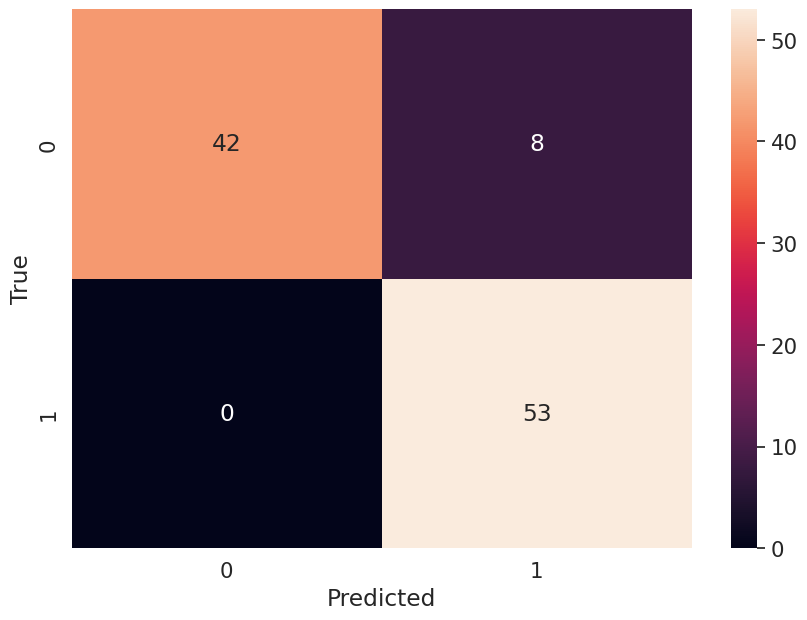

In [58]:
# Testing phase
model_A.eval()
model_B.eval()
model_C.eval()
central_model.eval()

test_labels = []
test_predictions = []

with torch.no_grad():
    for test_data_A, test_data_B, test_data_C, test_labels_batch in test_loader:
        test_data_A, test_data_B, test_data_C = \
            test_data_A.to(device), test_data_B.to(device), test_data_C.to(device)
        
        test_output_A = model_A(test_data_A)
        test_output_B = model_B(test_data_B)
        test_output_C = model_C(test_data_C)
        
        test_concatenated_output = torch.cat((test_output_A, test_output_B, test_output_C), dim=1)
        
        test_predictions_batch = central_model(test_concatenated_output)
        test_labels.extend(test_labels_batch.cpu().numpy())
        test_predictions.extend((test_predictions_batch.cpu().numpy() > 0.5).astype(int))

test_auprc = average_precision_score(test_labels, test_predictions)

print('Test AUPRC: ',test_auprc)

# Convert predictions and labels to arrays for evaluation
test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)

# Classification report
print("Classification Report:")
print(classification_report(test_labels, test_predictions))

# Confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(test_labels, test_predictions)
print(cm)

# Optional: Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


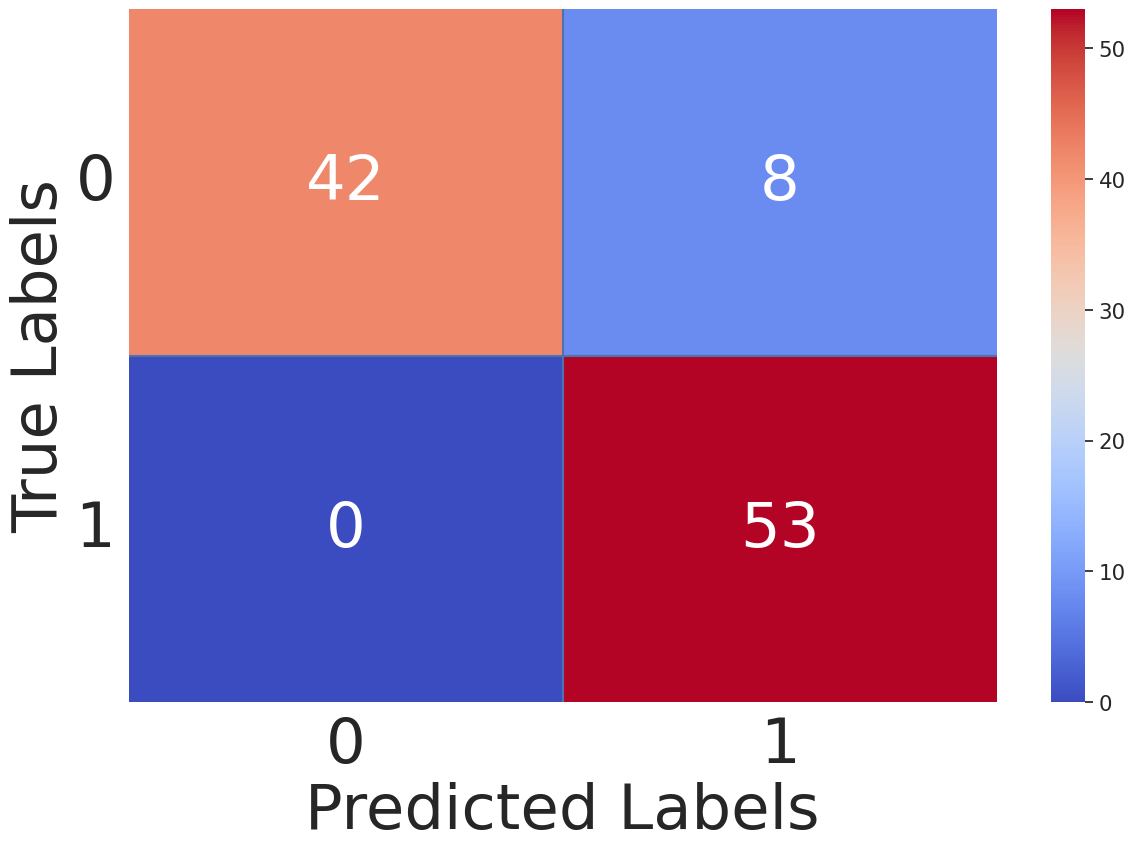

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example confusion matrix data
cm = np.array([[42, 8], [0, 53]])

# Create labels for the classes
classes = ['0', '1']

# Start the plot
plt.figure(figsize=(14, 9))
sns.set(font_scale=1.4)  # for label size
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", annot_kws={"size": 45})
ax.figure.axes[-1].yaxis.label.set_size(14)

# Labeling the axes
plt.ylabel('True Labels', fontsize=45)
plt.xlabel('Predicted Labels', fontsize=45)
plt.title('', fontsize=50)

# Tick labels
ax.set_xticklabels(classes, fontsize=45)
ax.set_yticklabels(classes, fontsize=45, rotation=0)

# Adding gridlines
ax.hlines([x for x in range(1, len(classes))], *ax.get_xlim())
ax.vlines([x for x in range(1, len(classes))], *ax.get_ylim())

# Save the figure as a PNG file with high quality
plt.savefig("H25.png", format='png', dpi=500, bbox_inches='tight', pad_inches=0.5)

plt.show()
